In [1]:
devtools::install_version("IMIS",
                          version = "0.1",
                          repos= "https://cran.dcc.uchile.cl")

Installing package into ‘/home/giparra/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)



$Surv
         2          3          4          5          6          7          8 
0.99500000 0.98575000 0.97291250 0.95707188 0.93874278 0.91837769 0.89637365 
         9         10         11         12         13         14         15 
0.87307833 0.84879544 0.82378959 0.79829064 0.77249758 0.74658203 0.72069133 
        16         17         18         19         20         21         22 
0.69495132 0.66946885 0.64433400 0.61962203 0.59539519 0.57170426 0.54859000 
        23         24         25         26         27         28         29 
0.52608435 0.50421161 0.48298935 0.46242937 0.44253844 0.42331901 0.40476980 
        30         31         32         33         34         35         36 
0.38688637 0.36966161 0.35308613 0.33714867 0.32183639 0.30713521 0.29303003 
        37         38         39         40         41         42         43 
0.27950495 0.26654348 0.25412871 0.24224343 0.23087030 0.21999193 0.20959096 
        44         45         46         47         48         49         50 
0.19965017 0.19015255 0.18108132 0.17242001 0.16415250 0.15626300 0.14873618 
        51         52         53         54         55         56         57 
0.14155706 0.13471112 0.12818429 0.12196293 0.11603386 0.11038433 0.10500206 
        58         59         60 
0.09987521 0.09499237 0.09034259

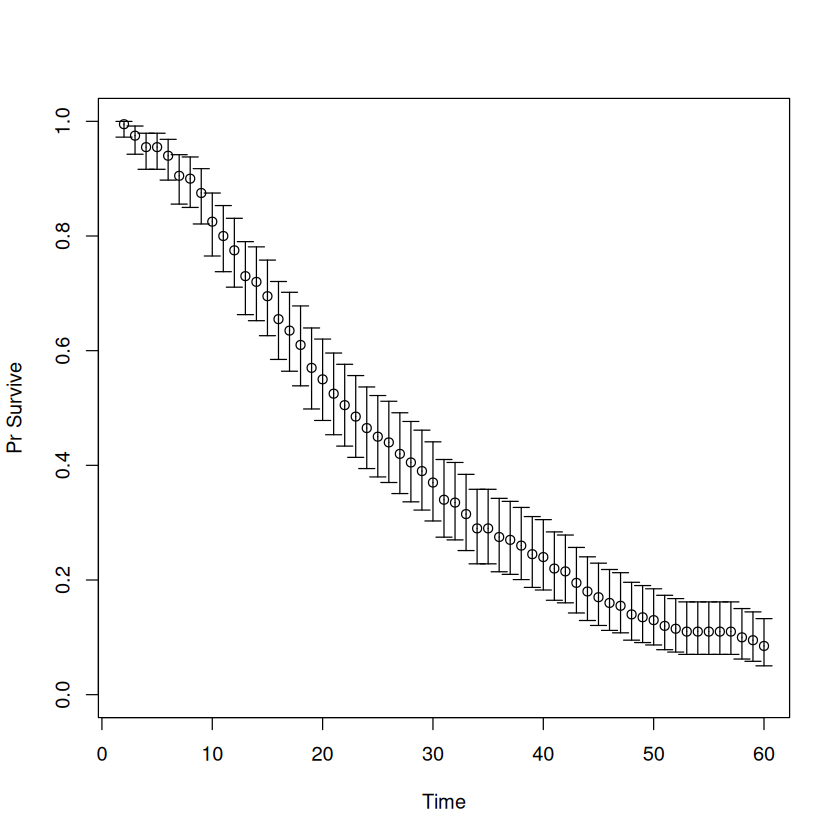

In [2]:
# *****************************************************************************
#
#
# Purpose: Bayesian calibration of the 3-State Cancer Relative Survival (CRS) 
#          Markov Model using Incremental Mixture Importance Sampling (IMIS)
#
# Authors: 
# This work is developed by the Decision Analysis in R for Technologies in Health 
# (DARTH) workgroup:
#
# - Fernando Alarid-Escudero, PhD
# - Eva A. Enns, MS, PhD 
# - M.G. Myriam Hunink, MD, PhD 
# - Hawre J. Jalal, MD, PhD 
# - Eline Krijkamp, PhD 
# - Petros Pechlivanoglou, PhD
# - Alan Yang, MSc
#
# *****************************************************************************
#
# Notes:
#
# Please acknowledge our work. See details to cite below:
#
# - Alarid-Escudero F, MacLehose RF, Peralta Y, Kuntz KM, Enns EA. 
#   Non-identifiability in model calibration and implications for 
#   medical decision making. Med Decis Making. 2018; 38(7):810-821.
#
# - Jalal H, Pechlivanoglou P, Krijkamp E, Alarid-Escudero F, Enns E, 
#   Hunink MG. An Overview of R in Health Decision Sciences. 
#   Med Decis Making. 2017; 37(3): 735-746.
#
# A walkthrough of the code could be found in the following link:
# - https://darth-git.github.io/calibSMDM2018-materials/
#
# *****************************************************************************

# ******************************************************************************
# 01 Calibration Overview ------------------------------------------------------
# ******************************************************************************

### 01.01 Model description  ---------------------------------------------------
# Model: 3-State Cancer Relative Survival (CRS) Markov Model
# Inputs to be calibrated: p_Mets, p_DieMets
# Targets: Survival data

### 01.02 Calibration method  --------------------------------------------------
# Method: Incremental Mixture Importance Sampling (IMIS)
# Goodness-of-fit measure: Sum of Log-Likelihood

# ******************************************************************************
# 02 Setup ---------------------------------------------------------------------
# ******************************************************************************

### 02.01 Clear environment  ---------------------------------------------------
rm(list = ls())

### 02.02 Load packages  -------------------------------------------------------
# Install pacman if not present
if (!requireNamespace("pacman", quietly = TRUE)) install.packages("pacman")

# Load pacman
library(pacman)

# Load (install if needed) CRAN packages
p_load(
  lhs,          # Latin Hypercube Sampling
  IMIS,         # Incremental Mixture Importance Sampling
  matrixStats,  # Summary statistics
  plotrix,      # Plotting with confidence intervals
  psych,        # Pairs panels
  ggplot2,      # Advanced plotting
  GGally,       # Pairwise plots
  dplyr,        # Data manipulation
  reshape2      # Data reshaping
)

# ******************************************************************************
# 03 Load calibration targets --------------------------------------------------
# ******************************************************************************

### 03.01 Load target data  ----------------------------------------------------
load("../../data/CRS_CalibTargets.RData")
lst_targets <- CRS_targets

### 03.02 Visualize calibration targets  ---------------------------------------
# TARGET 1: Survival ("Surv")
plotrix::plotCI(x = lst_targets$Surv$time, 
                y = lst_targets$Surv$value, 
                ui = lst_targets$Surv$ub,
                li = lst_targets$Surv$lb,
                ylim = c(0, 1), 
                xlab = "Time", 
                ylab = "Pr Survive")

# ******************************************************************************
# 04 Load model as a function --------------------------------------------------
# ******************************************************************************

### 04.01 Source model function  -----------------------------------------------
# Function inputs: parameters to be estimated through calibration
# Function outputs: model predictions corresponding to target data
source("../../code/Functions/CRS_MarkovModel_Function.R") # creates run_crs_markov()

### 04.02 Test model function  -------------------------------------------------
v_params_test <- c(p_Mets = 0.10, p_DieMets = 0.05)
run_crs_markov(v_params_test) # Test: function works correctly

# ******************************************************************************
# 05 Calibration specifications ------------------------------------------------
# ******************************************************************************

### 05.01 Set random seed  -----------------------------------------------------
set.seed(072218) # For reproducible sequence of random numbers

### 05.02 Define calibration parameters  ---------------------------------------
# Number of posterior samples desired
n_resamp <- 1000

# Names and number of parameters to calibrate
v_param_names <- c("p_Mets", "p_DieMets")
n_param       <- length(v_param_names)

# Search space bounds
lb <- c(p_Mets = 0.04, p_DieMets = 0.04) # lower bound
ub <- c(p_Mets = 0.16, p_DieMets = 0.16) # upper bound

### 05.03 Define calibration targets  ------------------------------------------
v_target_names <- c("Surv")
n_target       <- length(v_target_names)

p_Mets 
4.240527

[1] 4.240527 4.240527 4.240527 4.240527 4.240527 4.240527 4.240527 4.240527
 [9] 4.240527 4.240527

p_Mets 
69.44444

[1] 69.44444 69.44444 69.44444 69.44444 69.44444 69.44444 69.44444 69.44444
 [9] 69.44444 69.44444

[1] 142.7532

[1]  -352.55851  -597.91794  -323.23769   148.35219   149.06824  -434.76064
 [7] -1456.83952    66.43979   108.38922   155.32244

[1] 9.929821e+61

[1]  4.623576e-30  1.625406e-44  9.048351e+55  5.336427e+46  2.834761e+65
 [6]  0.000000e+00  0.000000e+00  3.817771e+62 7.400753e-165 3.259729e-282

p_Mets 
146.9938

[1]    65.74360  -310.86424  -102.40732 -1254.43137    44.50479  -679.55318
 [7]  -384.88547  -182.63735  -786.29944 -1624.15565

p_Mets 
6.895709e+63

[1]  0.000000e+00  3.921200e-91  0.000000e+00  0.000000e+00  0.000000e+00
 [6] 1.161896e-237 1.887703e-124  5.521934e+55  1.367014e-91  8.589864e+68

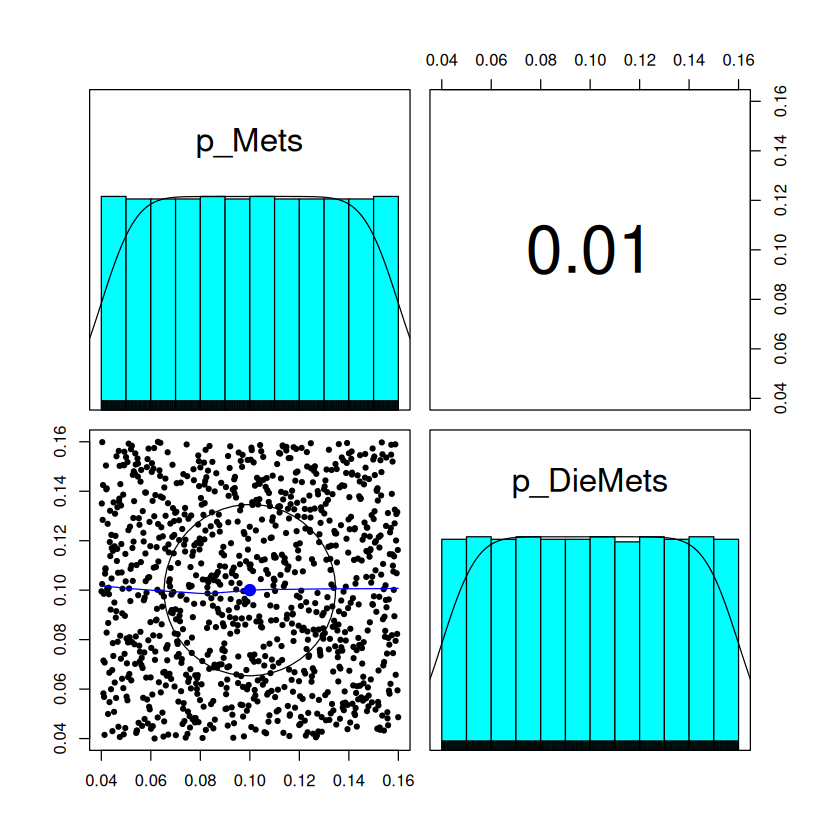

In [3]:
# ******************************************************************************
# 06 Prior distribution functions ----------------------------------------------
# ******************************************************************************

### 06.01 Function to sample from prior  ---------------------------------------
sample_prior <- function(n_samp){
  # Generate Latin Hypercube Sample
  m_lhs_unit   <- randomLHS(n = n_samp, k = n_param)
  m_param_samp <- matrix(nrow = n_samp, ncol = n_param)
  colnames(m_param_samp) <- v_param_names
  
  # Transform to parameter space using uniform distribution
  for (i in 1:n_param) {
    m_param_samp[, i] <- qunif(m_lhs_unit[, i],
                               min = lb[i],
                               max = ub[i])
  }
  return(m_param_samp)
}

### 06.02 Visualize prior samples  ---------------------------------------------
pairs.panels(sample_prior(1000))

### 06.03 Function to calculate log-prior  -------------------------------------
calc_log_prior <- function(v_params){
  if (is.null(dim(v_params))) { # If vector, change to matrix
    v_params <- t(v_params) 
  }
  n_samp <- nrow(v_params)
  colnames(v_params) <- v_param_names
  lprior <- rep(0, n_samp)
  
  # Calculate log-prior using uniform distribution
  for (i in 1:n_param) {
    lprior <- lprior + dunif(v_params[, i],
                             min = lb[i],
                             max = ub[i], 
                             log = TRUE)
  }
  return(lprior)
}

### 06.04 Function to calculate prior  -----------------------------------------
calc_prior <- function(v_params) { 
  exp(calc_log_prior(v_params)) 
}

### 06.05 Test prior functions  ------------------------------------------------
calc_log_prior(v_params = v_params_test)
calc_log_prior(v_params = sample_prior(10))
calc_prior(v_params = v_params_test)
calc_prior(v_params = sample_prior(10))

# ******************************************************************************
# 07 Likelihood functions ------------------------------------------------------
# ******************************************************************************

### 07.01 Function to calculate log-likelihood  --------------------------------
calc_log_lik <- function(v_params){
  if (is.null(dim(v_params))) { # If vector, change to matrix
    v_params <- t(v_params) 
  }
  n_samp <- nrow(v_params)
  v_llik <- matrix(0, nrow = n_samp, ncol = n_target) 
  llik_overall <- numeric(n_samp)
  
  for (j in 1:n_samp) {
    jj <- tryCatch({ 
      # Run model for parameter set v_params
      model_res <- run_crs_markov(v_params[j, ])
      
      # Calculate log-likelihood for TARGET 1: Survival
      v_llik[j, 1] <- sum(dnorm(x = lst_targets$Surv$value,
                                mean = model_res$Surv,
                                sd = lst_targets$Surv$se,
                                log = TRUE))
      
      # Calculate overall log-likelihood
      llik_overall[j] <- sum(v_llik[j, ])
    }, error = function(e) NA) 
    
    if (is.na(jj)) { llik_overall[j] <- -Inf }
  }
  return(llik_overall)
}

### 07.02 Function to calculate likelihood  ------------------------------------
calc_likelihood <- function(v_params){ 
  exp(calc_log_lik(v_params)) 
}

### 07.03 Test likelihood functions  -------------------------------------------
calc_log_lik(v_params = v_params_test)
calc_log_lik(v_params = sample_prior(10))
calc_likelihood(v_params = v_params_test)
calc_likelihood(v_params = sample_prior(10))

# ******************************************************************************
# 08 Posterior distribution functions ------------------------------------------
# ******************************************************************************

### 08.01 Function to calculate log-posterior  ---------------------------------
calc_log_post <- function(v_params) { 
  lpost <- calc_log_prior(v_params) + calc_log_lik(v_params)
  return(lpost) 
}

### 08.02 Function to calculate posterior  -------------------------------------
calc_post <- function(v_params) { 
  exp(calc_log_post(v_params)) 
}

### 08.03 Test posterior functions  --------------------------------------------
calc_log_post(v_params = v_params_test)
calc_log_post(v_params = sample_prior(10))
calc_post(v_params = v_params_test)
calc_post(v_params = sample_prior(10))

In [4]:
# ******************************************************************************
# 09 Run Bayesian calibration using IMIS ---------------------------------------
# ******************************************************************************

### 09.01 Record start time  ---------------------------------------------------
t_init <- Sys.time()

### 09.02 Define IMIS functions  -----------------------------------------------
prior          <- calc_prior
likelihood     <- calc_likelihood
sample.prior   <- sample_prior

### 09.03 Run IMIS algorithm  --------------------------------------------------
fit_imis <- IMIS(
  B = 1000,         # Incremental sample size at each iteration
  B.re = n_resamp,  # Desired posterior sample size
  number_k = 10,    # Maximum number of iterations
  D = 0             # Number of samples to be deleted at each iteration
)

### 09.04 Extract posterior samples  -------------------------------------------
m_calib_res <- fit_imis$resample

### 09.05 Calculate posterior diagnostics  -------------------------------------
# Calculate log-likelihood and posterior probability for each sample
m_calib_res <- cbind(
  m_calib_res, 
  "Overall_fit" = calc_log_lik(m_calib_res[, v_param_names]),
  "Posterior_prob" = calc_post(m_calib_res[, v_param_names])
)

# Normalize posterior probabilities
m_calib_res[, "Posterior_prob"] <- m_calib_res[, "Posterior_prob"] / 
  sum(m_calib_res[, "Posterior_prob"])

### 09.06 Calculate computation time  ------------------------------------------
comp_time <- Sys.time() - t_init
comp_time

[1] "10000 likelihoods are evaluated in 0.11 minutes"
[1] "Stage   MargLike   UniquePoint   MaxWeight   ESS"
[1]   1.000 151.028 229.801   0.015 135.816
[1]   2.000 151.135 367.870   0.013 226.304
[1]   3.000 151.080 508.382   0.003 573.865
[1]   4.000 151.057 617.922   0.003 823.727
[1]    5.000  151.065  708.392    0.002 1263.929


Time difference of 10.90982 secs

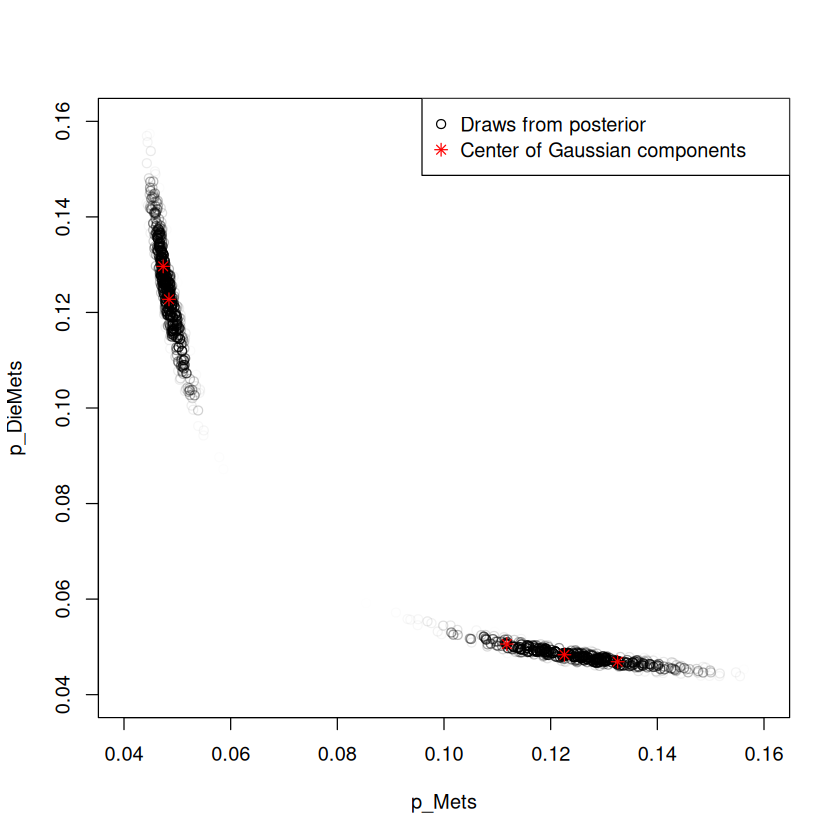

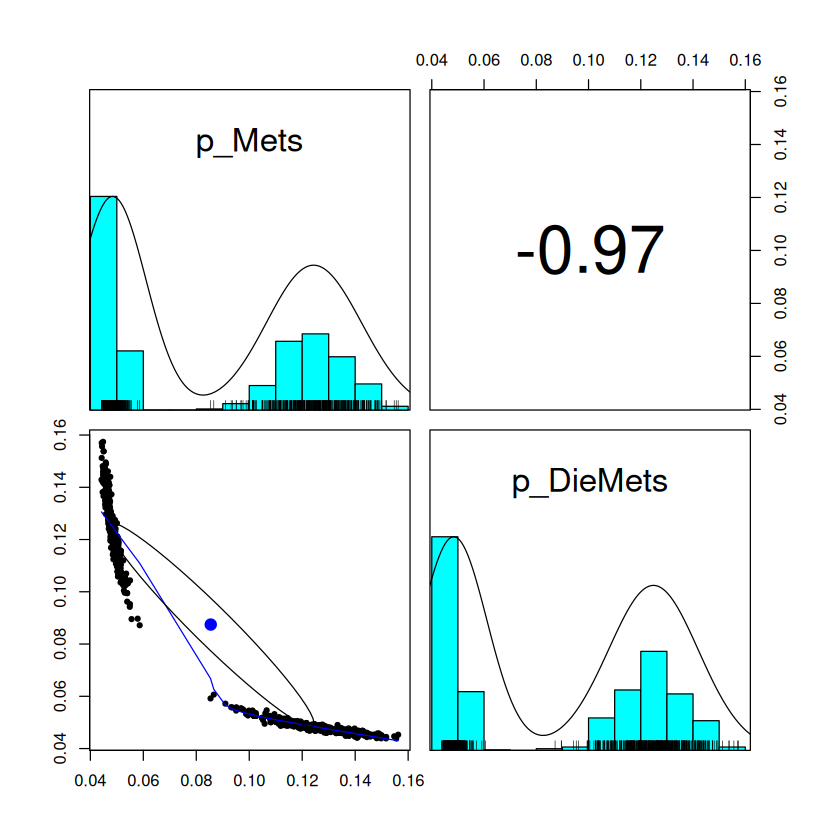

In [5]:
# ******************************************************************************
# 10 Explore posterior distribution --------------------------------------------
# ******************************************************************************

### 10.01 Plot posterior samples  ----------------------------------------------
# Color points by posterior probability
v_post_color <- scales::rescale(m_calib_res[, "Posterior_prob"])

plot(m_calib_res[, v_param_names],
     xlim = c(lb[1], ub[1]), 
     ylim = c(lb[2], ub[2]),
     xlab = v_param_names[1], 
     ylab = v_param_names[2],
     col = scales::alpha("black", v_post_color))

# Add centers of Gaussian components
points(fit_imis$center, col = "red", pch = 8)
legend("topright", 
       c("Draws from posterior", "Center of Gaussian components"),
       col = c("black", "red"), 
       pch = c(1, 8))

### 10.02 Pairwise plots with marginal histograms  -----------------------------
pairs.panels(m_calib_res[, v_param_names])

p_Mets  p_DieMets 
0.08546097 0.08745364

,2.5%,50%,97.5%
p_Mets,0.04515601,0.05389687,0.1450045
p_DieMets,0.04493458,0.10264587,0.1440099


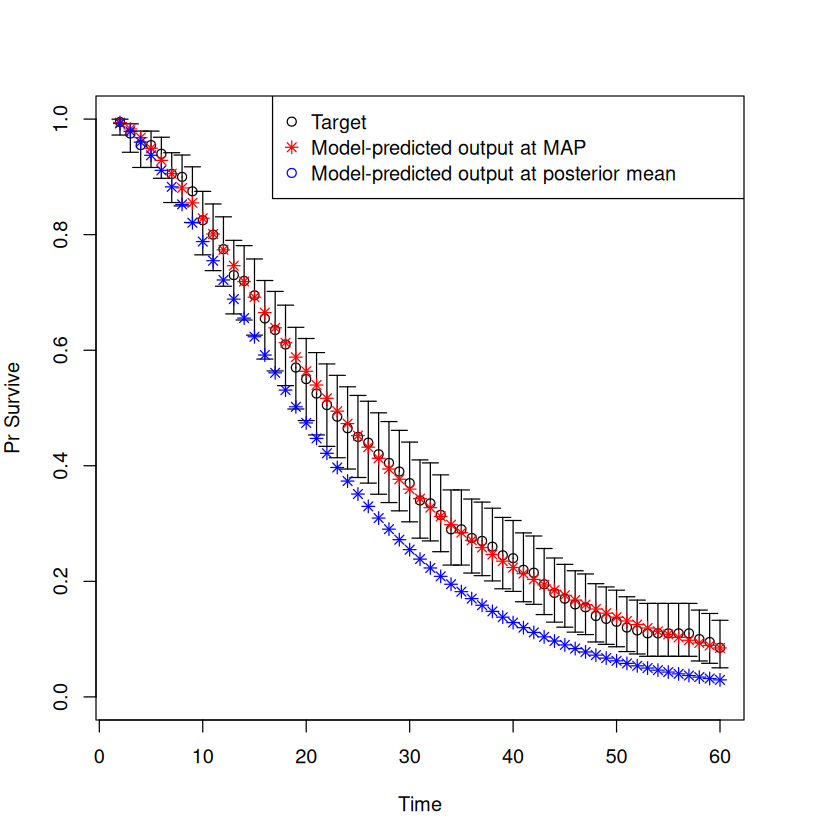

In [6]:
### 10.03 Calculate posterior summary statistics  ------------------------------
# Posterior mean
v_calib_post_mean <- colMeans(m_calib_res[, v_param_names])
v_calib_post_mean

# Posterior median and 95% credible interval
m_calib_res_95cr <- colQuantiles(m_calib_res[, v_param_names], 
                                 probs = c(0.025, 0.5, 0.975))
m_calib_res_95cr

# Maximum-a-posteriori (MAP) parameter set
v_calib_map <- m_calib_res[which.max(m_calib_res[, "Posterior_prob"]), ]

### 10.04 Compare model predictions to targets  --------------------------------
# Run model at MAP and posterior mean
v_out_best      <- run_crs_markov(v_calib_map[v_param_names])
v_out_post_mean <- run_crs_markov(v_calib_post_mean)

# Plot: Target vs MAP vs posterior mean
par(mar = c(5, 4, 4, 4)) 

plotrix::plotCI(x = lst_targets$Surv$time, 
                y = lst_targets$Surv$value, 
                ui = lst_targets$Surv$ub,
                li = lst_targets$Surv$lb,
                ylim = c(0, 1), 
                xlab = "Time", 
                ylab = "Pr Survive")

points(x = lst_targets$Surv$time, 
       y = v_out_best$Surv, 
       pch = 8, col = "red")

points(x = lst_targets$Surv$time, 
       y = v_out_post_mean$Surv, 
       pch = 8, col = "blue")

legend("topright", 
       legend = c("Target", 
                  "Model-predicted output at MAP",
                  "Model-predicted output at posterior mean"),
       col = c("black", "red", "blue"), 
       pch = c(1, 8))

In [7]:
dev.off()

null device 
          1

`stat_bin()` using `bins = 30`. Pick better value `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value `binwidth`.


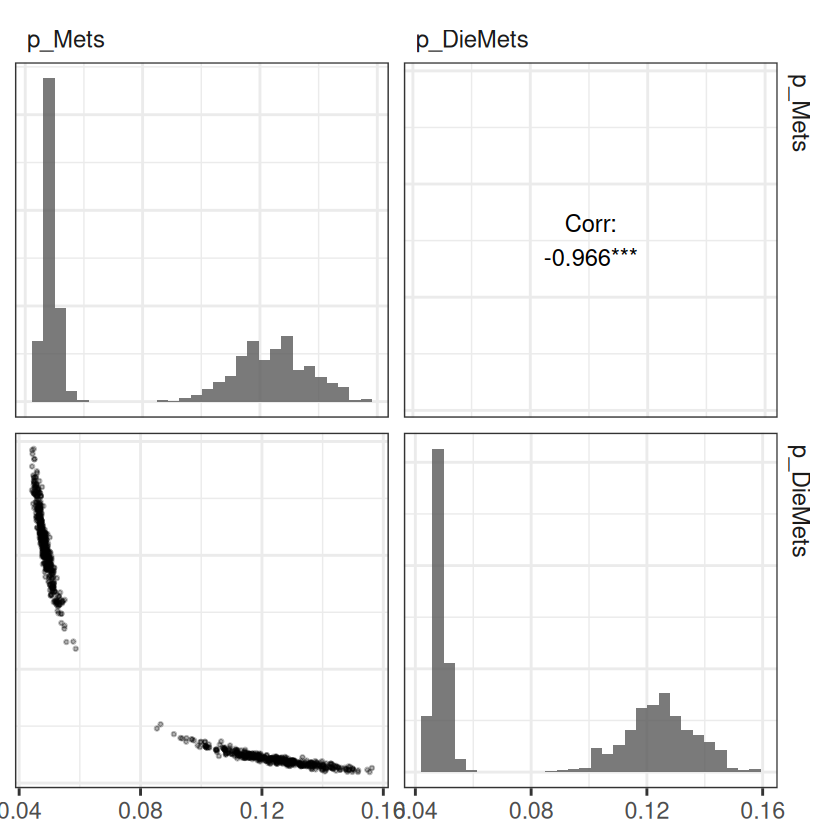

In [8]:
### 10.05 Advanced visualization: pairwise correlations  -----------------------
gg_post_pairs_corr <- GGally::ggpairs(
  data.frame(m_calib_res[, v_param_names]),
  upper = list(continuous = wrap("cor",
                                 color = "black",
                                 size = 5)),
  diag = list(continuous = wrap("barDiag",
                                alpha = 0.8)),
  lower = list(continuous = wrap("points", 
                                 alpha = 0.3,
                                 size = 0.7)),
  columnLabels = v_param_names
) +
  theme_bw(base_size = 18) +
  theme(axis.title.x = element_blank(),
        axis.text.x = element_text(size = 14),
        axis.title.y = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        strip.background = element_rect(fill = "white",
                                        color = "white"),
        strip.text = element_text(hjust = 0))

gg_post_pairs_corr

Using PDF as id variables

Using PDF as id variables

Warning message:
“The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead.”


 100% done

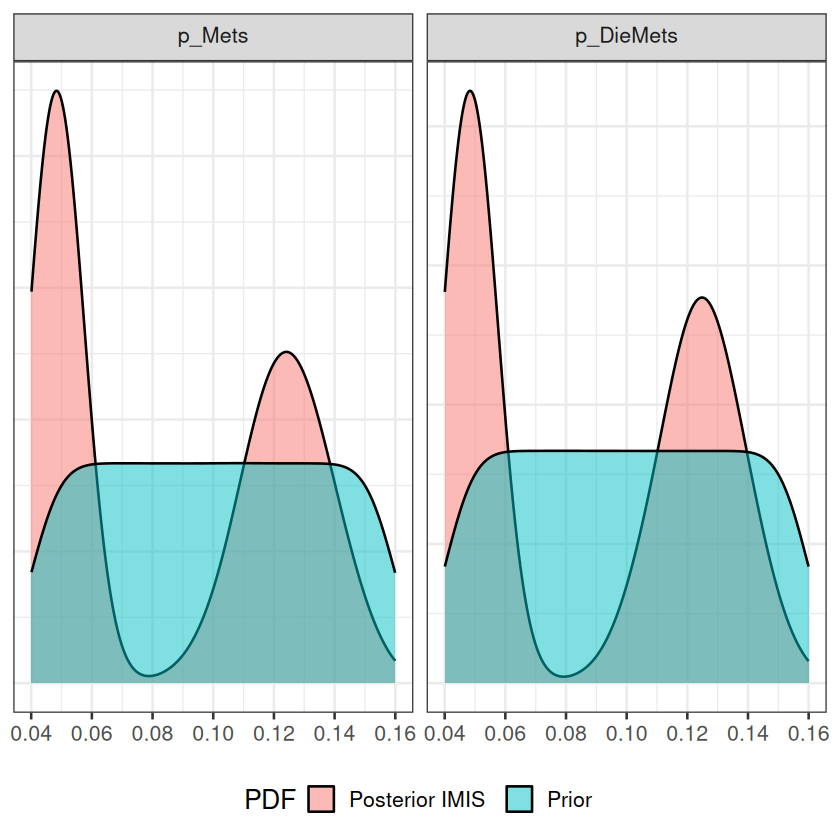

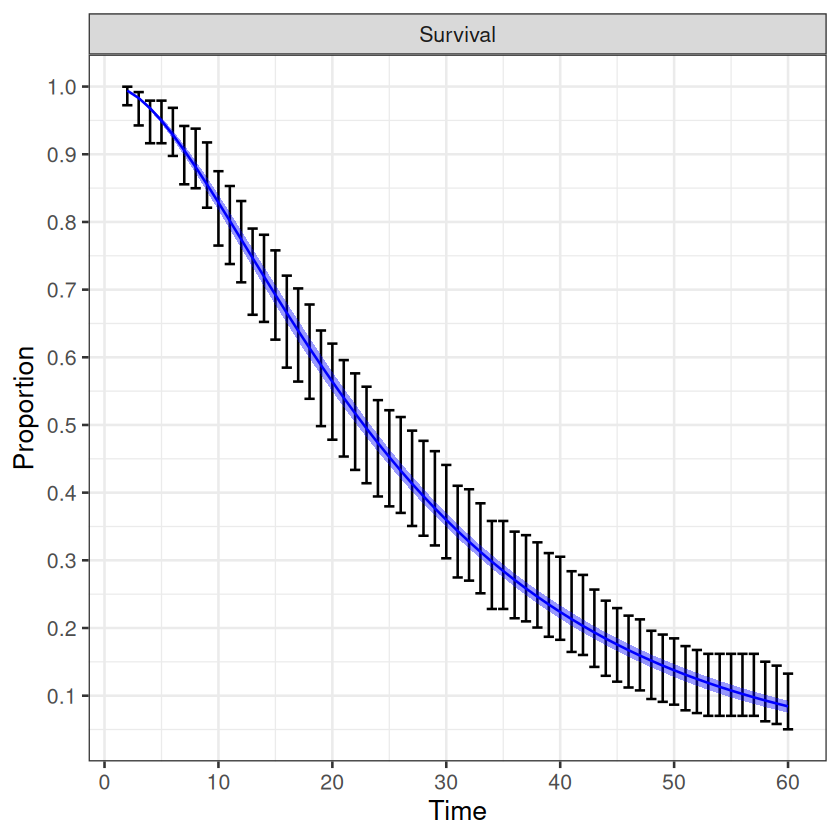

In [9]:
### 10.06 Prior vs posterior comparison  ---------------------------------------
# Sample from prior
m_samp_prior <- sample.prior(n_resamp)

# Prepare data for plotting
df_samp_prior <- reshape2::melt(
  cbind(PDF = "Prior", as.data.frame(m_samp_prior)), 
  variable.name = "Parameter"
)

df_samp_post_imis <- reshape2::melt(
  cbind(PDF = "Posterior IMIS", 
        as.data.frame(m_calib_res[, v_param_names])),
  variable.name = "Parameter"
)

df_samp_prior_post <- dplyr::bind_rows(df_samp_prior, df_samp_post_imis)

# Plot prior vs posterior
gg_prior_post_imis <- ggplot(df_samp_prior_post, 
                             aes(x = value, y = ..density.., fill = PDF)) +
  facet_wrap(~Parameter, scales = "free", 
             ncol = 4,
             labeller = label_parsed) +
  scale_x_continuous(n.breaks = 6) +
  geom_density(alpha = 0.5) +
  theme_bw(base_size = 16) +
  theme(legend.position = "bottom",
        axis.title.x = element_blank(),
        axis.title.y = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank())
gg_prior_post_imis

# ******************************************************************************
# 11 Propagate parameter uncertainty -------------------------------------------
# ******************************************************************************

### 11.01 Initialize output matrix  --------------------------------------------
m_out_surv <- matrix(NA, 
                     nrow = n_resamp, 
                     ncol = length(lst_targets$Surv$value))

### 11.02 Run model for each posterior sample  ---------------------------------
for (i in 1:n_resamp) {
  model_res_temp <- run_crs_markov(m_calib_res[i, v_param_names])
  m_out_surv[i, ] <- model_res_temp$Surv
  
  # Progress indicator
  if (i/100 == round(i/100, 0)) { 
    cat('\r', paste(i/n_resamp * 100, "% done", sep = ""))
  }
}

### 11.03 Calculate posterior-predicted mean  ----------------------------------
v_out_surv_post_mean <- colMeans(m_out_surv)

### 11.04 Calculate posterior-predicted 95% credible interval  -----------------
m_out_surv_95cri <- colQuantiles(m_out_surv, probs = c(0.025, 0.975))

### 11.05 Prepare data for plotting  -------------------------------------------
df_out_post <- data.frame(
  Type = "Model output",
  bind_cols(Outcome = "Survival", 
            time = lst_targets[[1]]$time,
            value = v_out_surv_post_mean,
            lb = m_out_surv_95cri[, 1],
            ub = m_out_surv_95cri[, 2])
)

df_out_post$Outcome <- ordered(df_out_post$Outcome, levels = c("Survival"))

### 11.06 Plot targets vs model-predicted output  ------------------------------
df_targets <- data.frame(
  cbind(Type = "Target", 
        Outcome = "Survival", 
        lst_targets[[1]])
)

df_targets$Outcome <- ordered(df_targets$Outcome, levels = c("Survival"))

ggplot(df_targets, aes(x = time, y = value, ymin = lb, ymax = ub)) +
  geom_errorbar() +
  geom_line(data = df_out_post, 
            aes(x = time, y = value), 
            col = "blue") +
  geom_ribbon(data = df_out_post,
              aes(ymin = lb, ymax = ub), 
              alpha = 0.4, 
              fill = "blue") +
  facet_wrap(~ Outcome, scales = "free_x") +
  scale_x_continuous("Time", n.breaks = 8) +
  scale_y_continuous("Proportion", n.breaks = 8) +
  theme_bw(base_size = 16)

